List the approach names below:

In [2]:
MODELS = ['pointnet', 'pointnet++', 'so-net', 'kcnet', 'deepsets']

For every model there are 2 files generated in numpy binary format:

  **probabilities.npy** - numpy array of size **MODELS COUNT x TEST POINT CLOUDS CLOUD x CLASSES COUNT** with output classification probability for each of 10 individually trained models

  **true_labels.npy** - numpy array of size **TEST POINT CLOUDS CLOUD** with true labels data

In [3]:
CLASS_NAMES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl',
               'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser',
               'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop',
               'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio',
               'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet',
               'tv_stand', 'vase', 'wardrobe', 'xbox']
CLASSES_COUNT = 40
MODELS_COUNT = 10

import os
import numpy as np
probabilities = {}
true_labels = {}
for model in MODELS:
    prob_filepath = os.path.join(model, 'probabilities.npy')
    probabilities[model] = np.load(prob_filepath)
    probabilities[model] = np.transpose(probabilities[model], axes=(2, 0, 1))
    label_filepath = os.path.join(model, 'true_labels.npy')
    true_labels[model] = np.load(label_filepath)

Now, we want to know how instance classification accuracy depends on the number of the ensemble of independently train models. We will check two ensembling methods: mean and mode operation and for each number of ensembled models there will be ten different sets taken into consideration and the median value will be shown on the figures below.

In [172]:
####################################################################################
# Constants
####################################################################################

ENSEMBLE_MODELS_NUMBER = 10

import math
import statistics
from scipy import stats

####################################################################################
# Get random subsets
####################################################################################

def get_k_combinations_of_n_elems(n, k, rep):
    """
    Get rep different k-combinations of set of n numbers. If requested reps is greater
    than possible combinations number just return all possible combinations. In our case:
    n - maximum number of ensembled models
    k - actual number of ensembled models
    rep - how many different k subsets of n we want to generate.    
    """
    c_n_k = math.factorial(n) / math.factorial(k) / math.factorial(n-k)
    combinations_number = min(c_n_k, rep)
    
    subsets = []   
    while len(subsets) != combinations_number:
        candidate = np.sort(np.random.choice(n, k, replace=False))
        if not np.array([(el == candidate).all() for el in subsets]).any():
            subsets.append(candidate)
    return np.array(subsets)

subsets = {}
for num_ens in range(1, ENSEMBLE_MODELS_NUMBER+1):
    subset = get_k_combinations_of_n_elems(len(probabilities[model]), num_ens, ENSEMBLE_MODELS_NUMBER)
    subsets[num_ens] = subset

####################################################################################
# Calc acc with mode
####################################################################################

instance_accuracy_mode = {}
for model in MODELS:
    
    # Initialize instance accuracy var
    instance_accuracy_mode[model + '_min'] = {}
    instance_accuracy_mode[model + '_max'] = {}
    instance_accuracy_mode[model + '_med'] = {}
    
    instance_accuracy_mode[model] = {}
    for num_ens in subsets:
        num_ens_accs = []
        for subset in subsets[num_ens]:
            preds = []
            true = true_labels[model]
            for model_no in subset:
                preds.append(np.argmax(probabilities[model][model_no], axis=-1))
            preds = np.transpose(np.array(preds))
            preds = np.squeeze(stats.mode(preds, axis=-1)[0])
            accy = float(np.sum(preds == true))/len(true)
            num_ens_accs.append(accy)

        # Remember
        instance_accuracy_mode[model + '_min'][num_ens] = np.min(num_ens_accs)
        instance_accuracy_mode[model + '_max'][num_ens] = np.max(num_ens_accs)
        instance_accuracy_mode[model + '_med'][num_ens] = statistics.median(num_ens_accs)
        
####################################################################################
# Calc acc with mean
####################################################################################

instance_accuracy_mean = {}
for model in MODELS:

    # Initialize instance accuracy var
    instance_accuracy_mean[model + '_min'] = {}
    instance_accuracy_mean[model + '_max'] = {}
    instance_accuracy_mean[model + '_med'] = {}
        
    for num_ens in subsets:
        num_ens_accs = []
        for subset in subsets[num_ens]:
            preds = []
            true = true_labels[model]
            for model_no in subset:
                preds.append(probabilities[model][model_no])
            preds = np.transpose(np.array(preds), axes=(1,2,0))
            preds = np.argmax(np.mean(preds, axis=-1), axis=-1)
            accy = float(np.sum(preds == true))/len(true)
            num_ens_accs.append(accy)
            
        # Remember
        instance_accuracy_mean[model + '_min'][num_ens] = np.min(num_ens_accs)
        instance_accuracy_mean[model + '_max'][num_ens] = np.max(num_ens_accs)
        instance_accuracy_mean[model + '_med'][num_ens] = statistics.median(num_ens_accs)

Plot instance accuracy for two aggregation methods in the function of ensambled individually trained models.

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_accuracy(ax, instance_accuracy, aggregation_method='mode', models_order=[], with_label=True):
    handles = []
    models = instance_accuracy.keys()
    if len(models_order):
        models = models_order

    for model in models:
        x = instance_accuracy[model].keys()
        y = [instance_accuracy[model][i] for i in x]
        handle, = ax.plot(x, y, label=model)
        handles.append(handle)
    if aggregation_method is not None:
        ax.set_title('Aggregation method: ' + aggregation_method)
    ax.set_xlabel('Number of ensembled models')
    ax.set_ylabel('Instance classification accuracy')
    
    # Set legend outside the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.2,
                     box.width, box.height * 0.8])

    # Put a legend below current axis
    ax.legend(handles=handles, loc='upper center',
              bbox_to_anchor=(0.5, -0.1), prop={'size': 8},
              fancybox=True, shadow=True, ncol=5)
    
    # Show tick labels
    for tk in ax.get_yticklabels():
        tk.set_visible(True)

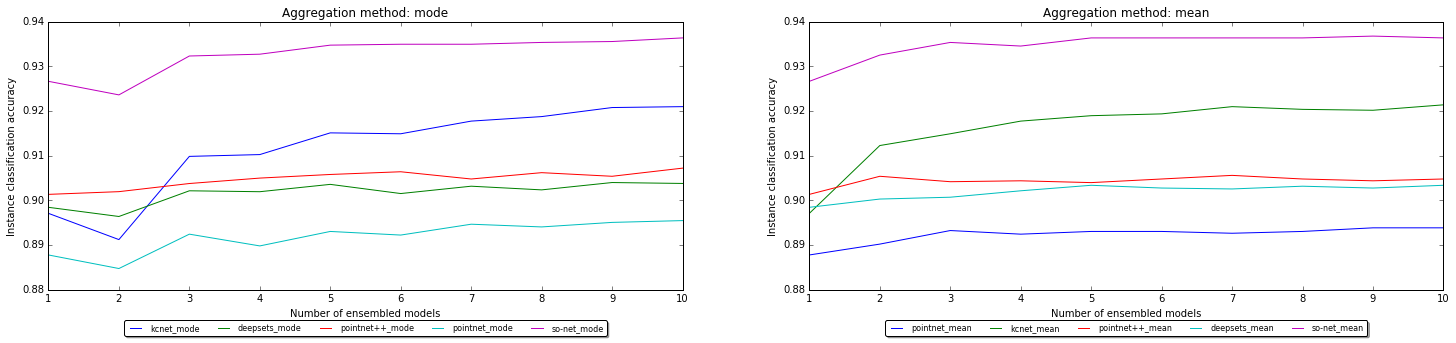

In [190]:
median_models = ['pointnet_med', 'pointnet++_med', 'deepsets_med', 'kcnet_med', 'so-net_med']
instance_accuracy_mean_median = {(key.split('_')[0]+'_mean'):value for key, value in instance_accuracy_mean.items() if key in median_models}
#instance_accuracy_mode_median = {(key + '_mode'):value for key, value in instance_accuracy_mode.items()}
instance_accuracy_mode_median = {(key.split('_')[0]+'_mode'):value for key, value in instance_accuracy_mode.items() if key in median_models}

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 6))
plot_accuracy(ax1, instance_accuracy_mode_median, 'mode')
plot_accuracy(ax2, instance_accuracy_mean_median, 'mean')

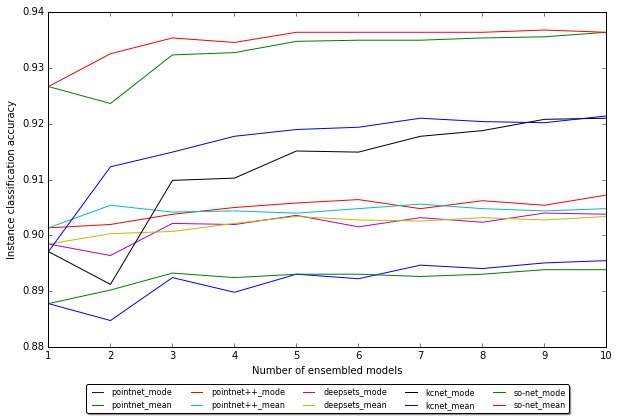

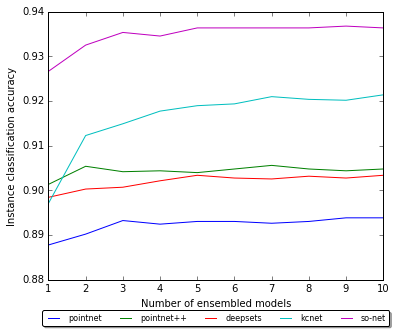

In [237]:
f, ax  = plt.subplots(1, 1, sharey=True, figsize=(10, 7.5))
instance_accuracy = dict(instance_accuracy_mean_median.items() + instance_accuracy_mode_median.items())
models_order = ['pointnet_mode', 'pointnet_mean', 'pointnet++_mode', 'pointnet++_mean', 'deepsets_mode', 'deepsets_mean',
                'kcnet_mode', 'kcnet_mean', 'so-net_mode', 'so-net_mean']
plot_accuracy(ax, instance_accuracy, None, models_order=models_order)

f, ax  = plt.subplots(1, 1, sharey=True, figsize=(6, 6))
instance_accuracy = {(key.split('_')[0]):value for key, value in instance_accuracy_mean.items() if key in median_models}
models_order = ['pointnet', 'pointnet++', 'deepsets', 'kcnet', 'so-net']
plot_accuracy(ax, instance_accuracy, None, models_order=models_order)

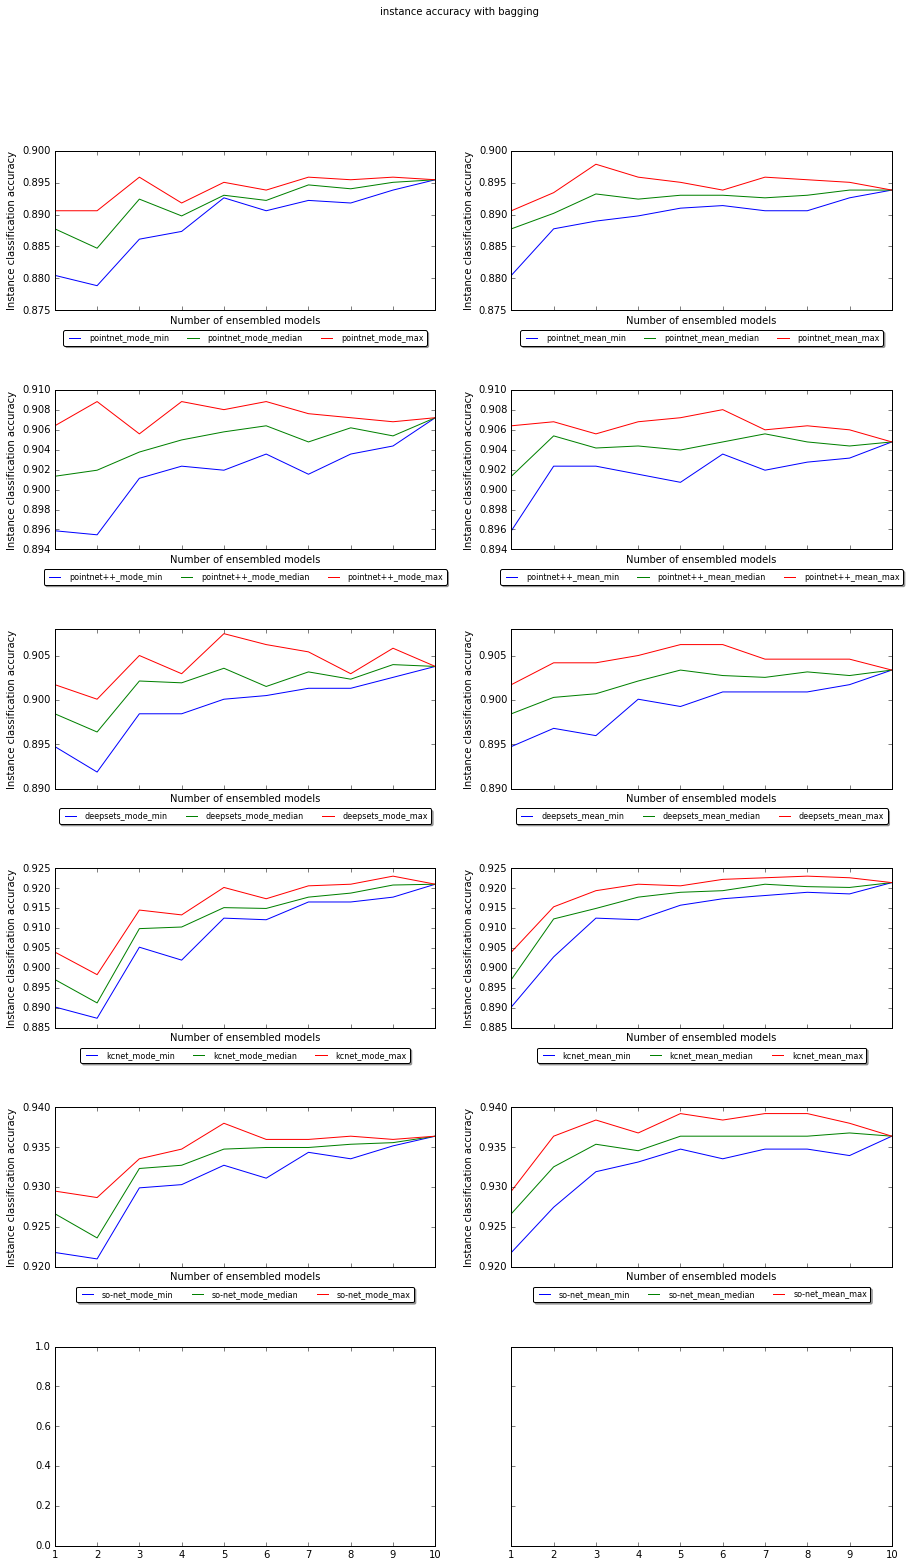

In [194]:
cols = 2
rows = 6
f, axes = plt.subplots(rows, cols, figsize=(15, 25), sharex='col', sharey='row')
f.suptitle('instance accuracy with bagging')
#f.subplots_adjust(hspace=0.1)

for row, model in enumerate(['pointnet', 'pointnet++', 'deepsets', 'kcnet', 'so-net']):
    instance_accuracy = {}
    instance_accuracy[model + '_mode_min'] = instance_accuracy_mode[model +'_min']
    instance_accuracy[model + '_mode_median'] = instance_accuracy_mode[model +'_med']
    instance_accuracy[model + '_mode_max'] = instance_accuracy_mode[model +'_max']
    plot_accuracy(axes[row][0], instance_accuracy, None, models_order=[model + '_mode_min', model + '_mode_median', model + '_mode_max'])
    
    instance_accuracy = {}
    instance_accuracy[model + '_mean_min'] = instance_accuracy_mean[model +'_min']
    instance_accuracy[model + '_mean_median'] = instance_accuracy_mean[model +'_med']
    instance_accuracy[model + '_mean_max'] = instance_accuracy_mean[model +'_max']
    plot_accuracy(axes[row][1], instance_accuracy, None, models_order=[model + '_mean_min', model + '_mean_median', model + '_mean_max'])

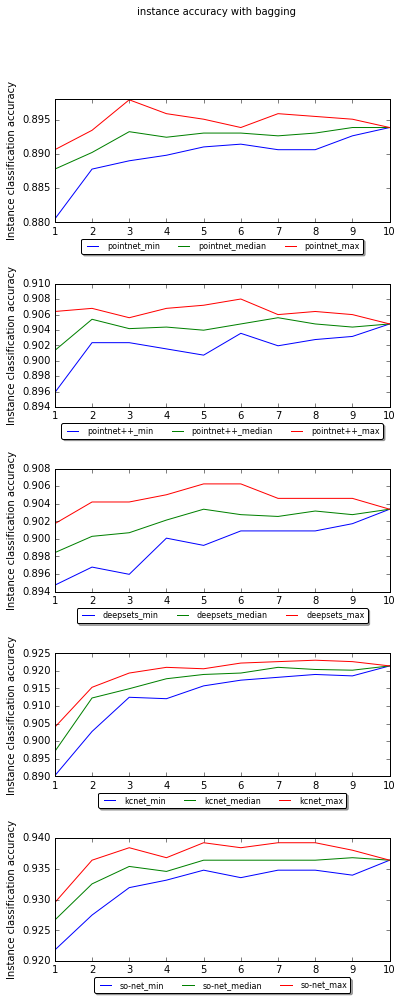

In [250]:
cols = 1
rows = 5
f, axes = plt.subplots(rows, cols, figsize=(6, 16), sharex='col', sharey='row')
f.suptitle('instance accuracy with bagging')
#f.subplots_adjust(hspace=0.1)

for idx, model in enumerate(['pointnet', 'pointnet++', 'deepsets', 'kcnet', 'so-net']):   
    instance_accuracy = {}
    instance_accuracy[model + '_min'] = instance_accuracy_mean[model +'_min']
    instance_accuracy[model + '_median'] = instance_accuracy_mean[model +'_med']
    instance_accuracy[model + '_max'] = instance_accuracy_mean[model +'_max']
    plot_accuracy(axes[idx], instance_accuracy, None, models_order=[model + '_min', model + '_median', model + '_max'])
    
    # Show tick labels
    for tk in axes[idx].get_xticklabels():
        tk.set_visible(True)
    

In [201]:
for model in MODELS:
    print (model, 100*instance_accuracy_mode[model +'_med'][1], 100*instance_accuracy_mode[model +'_med'][ENSEMBLE_MODELS_NUMBER], 100*(instance_accuracy_mode[model +'_med'][ENSEMBLE_MODELS_NUMBER] - instance_accuracy_mode[model +'_med'][1]))

('pointnet', 88.77633711507293, 89.54619124797406, 0.7698541329011377)
('pointnet++', 90.13371150729336, 90.72123176661265, 0.5875202593192852)
('so-net', 92.66612641815234, 93.63857374392221, 0.972447325769854)
('kcnet', 89.70826580226905, 92.09886547811993, 2.3905996758508907)
('deepsets', 89.84375, 90.37828947368422, 0.5345394736842146)


Now let's calc class classification accuracy.

In [221]:
import sklearn.metrics as metrics

class_accuracy = {}
for model in ['pointnet', 'pointnet++', 'so-net', 'kcnet']: #'deepsets'
    class_accuracy[model] = {}
    for num_ens in subsets:
        num_ens_accs = {}
        for class_idx in range(CLASSES_COUNT):
            num_ens_accs[class_idx] = []
        class_accuracy[model][num_ens] = {}
        for subset in subsets[num_ens]:
            
            # Get true labels and predictions
            preds = []
            true = true_labels[model]
            
            # MODE ############################################
            #for model_no in subset:
            #    preds.append(np.argmax(probabilities[model][model_no], axis=-1))
            #preds = np.transpose(np.array(preds))
            #preds = np.squeeze(stats.mode(preds, axis=-1)[0])
            
            # MEAN ############################################
            for model_no in subset:
                preds.append(probabilities[model][model_no])
            preds = np.transpose(np.array(preds), axes=(1,2,0))
            preds = np.argmax(np.mean(preds, axis=-1), axis=-1)
            
            # Confusion matrix analysis
            confusion_matrix = metrics.confusion_matrix(true, preds)
            class_acc = []
            for class_idx in range(CLASSES_COUNT):
                
                true_pos = float(np.sum(confusion_matrix[class_idx]))                                              # sum in rows
                flse_pos = float(np.sum(confusion_matrix[:, class_idx]) - confusion_matrix[class_idx, class_idx])  # sum in cols without querry
                flse_neg = float(np.sum(confusion_matrix[class_idx]) - confusion_matrix[class_idx, class_idx])     # sum in rows without querry
                
                #precsn = true_pos / (true_pos + flse_pos)
                #recall = true_pos / (true_pos + flse_neg)
                #f1_scr = 2 * precsn * recall / (precsn + recall)
                #print (model, num_ens, class_idx, np.sum(preds == class_idx), np.sum(true == class_idx), np.sum(confusion_matrix[class_idx]))
                acc = np.sum(float(confusion_matrix[class_idx, class_idx]) / np.sum(confusion_matrix[class_idx]))
                num_ens_accs[class_idx].append(acc)

        for class_idx in range(CLASSES_COUNT):
            class_accuracy[model][num_ens][class_idx] = statistics.median(num_ens_accs[class_idx])

Now plot class accuracy in the function of ensambled individually trained models.

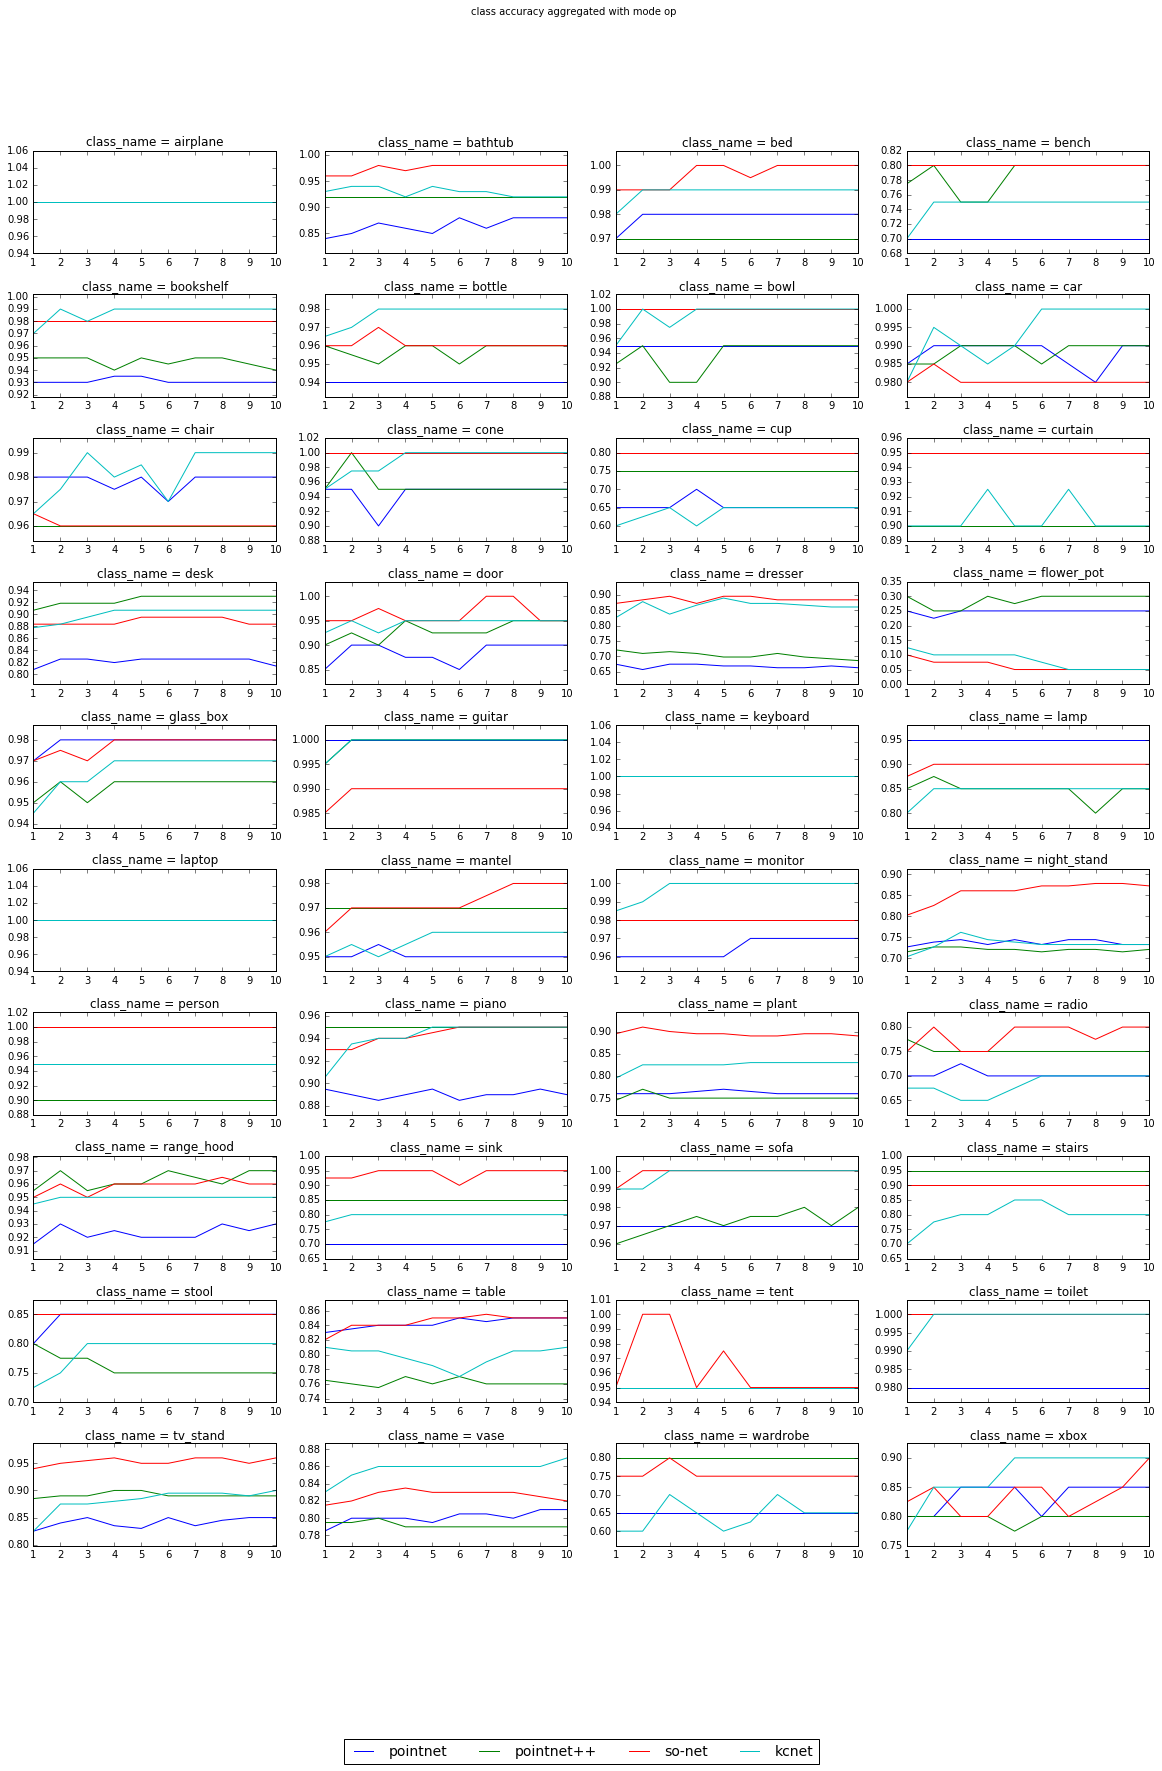

In [232]:
####################################################################################
# Calc acc with mean
####################################################################################

x = {}
y = {}
for model in ['pointnet', 'pointnet++', 'so-net', 'kcnet']: #'deepsets':
    x[model] = []
    y[model] = dict([(idx, []) for idx in range(CLASSES_COUNT)])
    for num_ens in class_accuracy[model].keys():
        x[model].append(num_ens)
        for class_idx in range(CLASSES_COUNT):
            y[model][class_idx].append(class_accuracy[model][num_ens][class_idx])

####################################################################################
# Display
####################################################################################

cols = 4
rows = 10
f, axes = plt.subplots(rows, cols, figsize=(20, 25))
f.suptitle('class accuracy aggregated with mode op')
f.subplots_adjust(hspace=0.4)
for row in range(rows):
    for col in range(cols):
        
        # Calc pos
        handles = []
        class_idx = row*cols + col
        if class_idx >= CLASSES_COUNT:
            break
            
        # Draw
        model_max = 0.
        model_min = 1.
        for model in ['pointnet', 'pointnet++', 'so-net', 'kcnet']: #'deepsets':
            handle, = axes[row][col].plot(x[model], y[model][class_idx], label=model)
            model_max = max(model_max, np.max(y[model][class_idx]))
            model_min = min(model_min, np.min(y[model][class_idx]))
            handles.append(handle)
            
        # better Y lim 
        diff = model_max - model_min
        if diff != 0:
            axes[row][col].set_ylim((model_min-0.2*diff, model_max+0.2*diff))
        axes[row][col].set_title('class_name = ' + CLASS_NAMES[class_idx])
        

f.legend(handles, ['pointnet', 'pointnet++', 'so-net', 'kcnet'], loc = 'lower center', ncol=5, prop={'size': 14})
f.savefig('class_classification_accuracy.png', bbox_inches='tight')